In [1]:
from db_connection import create_connection
from db_connection import query_data
from db_connection import query_sql_file

from preprocessing import process_diagnoses

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Connect to the MIMIC-III database
con = create_connection()

In [3]:
query = \
"""
SELECT d1.icd9_code, d2.short_title, COUNT(d1.hadm_id) AS total_admissions
	FROM diagnoses_icd AS d1
	JOIN d_icd_diagnoses AS d2
	ON d1.icd9_code = d2.icd9_code
	GROUP BY d1.icd9_code, d2.short_title;
"""
diagnoses = query_data(query, con)
print(diagnoses.head())

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


  icd9_code               short_title  total_admissions
0      3897     Deaf, nonspeaking NEC                11
1     78864         Urinary hesitancy                 5
2     58881  Sec hyperparathyrd-renal               169
3     E9444     Adv eff diuretics NEC               123
4      8360  Tear med menisc knee-cur                 5


In [4]:
# 1. Data Cleaning
diagnoses['short_title'] = diagnoses['short_title'].apply(process_diagnoses.clean_text)
print(diagnoses.head())

  icd9_code               short_title  total_admissions
0      3897      deaf nonspeaking nec                11
1     78864         urinary hesitancy                 5
2     58881  sec hyperparathyrd renal               169
3     E9444     adv eff diuretics nec               123
4      8360  tear med menisc knee cur                 5


In [5]:
# 2. Feature Extraction
tfidf_matrix = process_diagnoses.tfidf_diagnoses(diagnoses)
print(tfidf_matrix)

  (0, 2866)	0.2108064900342839
  (0, 2969)	0.6912165448538632
  (0, 1038)	0.6912165448538632
  (1, 1929)	0.8047714441114745
  (1, 4571)	0.5935848066980254
  (2, 3695)	0.49253249204318406
  (2, 2028)	0.7105108027986868
  (2, 3865)	0.5025794896213895
  (3, 1232)	0.7442671393819249
  (3, 1351)	0.42137587212562005
  (3, 89)	0.4562684883191417
  (3, 2866)	0.2456173165588795
  (4, 990)	0.45608313730272826
  (4, 2363)	0.39144204814107414
  (4, 2650)	0.5137940075071333
  (4, 2615)	0.4083689318901261
  (4, 4276)	0.45608313730272826
  (5, 786)	0.5060616384243356
  (5, 2982)	0.2791126192474566
  (5, 2227)	0.4851326022855289
  (5, 831)	0.6562348071321517
  (6, 4654)	0.6688580761798937
  (6, 2456)	0.5318463968921303
  (6, 2877)	0.3172146179154131
  (6, 2539)	0.3553092431581672
  :	:
  (6833, 1840)	0.7913978855351528
  (6833, 4374)	0.6113013878362203
  (6834, 2161)	0.6138843717348764
  (6834, 4575)	0.7022332453310566
  (6834, 3106)	0.36057516177835663
  (6835, 3497)	0.6646132729095627
  (6835, 505)	

In [8]:
from sklearn.cluster import KMeans

num_clusters = 200

km = KMeans(n_clusters=num_clusters)

# Fit the KMeans object to the TF-IDF features
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
print(clusters)

diagnoses['cluster'] = clusters

C:\Users\Perdorues\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[77, 108, 27, 10, 189, 149, 19, 95, 108, 108, 77, 116, 108, 108, 77, 183, 46, 44, 127, 56, 71, 108, 108, 186, 38, 108, 124, 194, 141, 29, 62, 46, 70, 25, 182, 112, 184, 34, 37, 150, 139, 29, 108, 119, 187, 191, 51, 108, 14, 70, 108, 19, 108, 50, 46, 108, 94, 108, 10, 143, 108, 108, 78, 101, 6, 161, 108, 108, 139, 10, 85, 7, 46, 108, 186, 102, 75, 25, 137, 108, 29, 91, 159, 108, 184, 116, 108, 21, 32, 108, 16, 108, 111, 12, 171, 108, 48, 193, 53, 16, 139, 46, 104, 52, 75, 43, 65, 51, 161, 157, 100, 90, 153, 46, 116, 31, 21, 62, 108, 10, 145, 91, 46, 176, 20, 26, 87, 108, 69, 108, 77, 135, 19, 3, 149, 108, 192, 42, 102, 2, 157, 16, 6, 108, 23, 2, 108, 108, 148, 1, 59, 23, 19, 138, 188, 108, 3, 157, 16, 158, 154, 6, 108, 3, 171, 46, 10, 168, 64, 190, 68, 183, 46, 108, 176, 77, 68, 56, 126, 48, 186, 111, 108, 79, 27, 108, 108, 108, 46, 168, 19, 199, 133, 26, 37, 45, 56, 89, 108, 139, 19, 46, 152, 145, 143, 127, 183, 19, 35, 108, 172, 108, 46, 1, 171, 184, 134, 117, 71, 65, 108, 24, 65, 37,

In [15]:
print(diagnoses.short_title[diagnoses.cluster == 33])

239      spin cord inj mult site
293            spin cord inj nos
486     spin bif w hydrceph lumb
1499     spin sten lumbr w claud
2135    spin bif w hydroceph nos
2284    spin bif w hydrceph cerv
3325    spin sten lumbr wo claud
3658       c c spin cord inj nec
4461           spin cord inj nec
4606       c c spin cord inj nos
4719       c c spin cord inj nos
5649       c c spin cord inj nec
5893           spin cord inj nec
Name: short_title, dtype: object


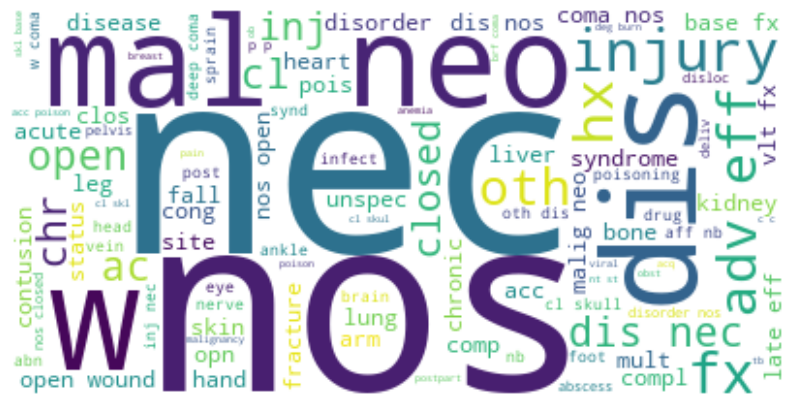

In [17]:
from wordcloud import WordCloud

text = ' '.join(diagnoses['short_title'])
wordcloud = WordCloud(background_color='white', max_words=100, contour_color='black')

wordcloud.generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

C:\Users\Perdorues\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


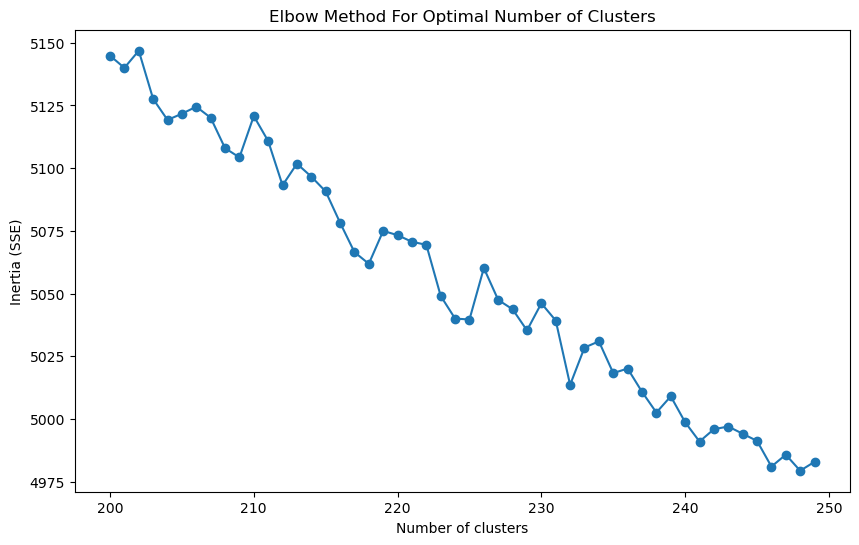

In [18]:
clusters_range = range(200, 250)

sse = []

for num_clusters in clusters_range:
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_matrix)
    sse.append(km.inertia_)

# Plot the SSE for each number of clusters
plt.figure(figsize=(10,6))
plt.plot(clusters_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()